In [1]:
# generic imports
import numpy as np
import pandas as pd
import cvxpy as cp
import math

In [2]:
# initial time step and final time under control
# 100,000 seconds is a little over a day
timeStep = 100
numSteps = 1000

# inital x sattelite (x,y,z,dx,dy,dz)
x_0 = np.array([0,1,0,0,0,0]).reshape((6,1))

# phi matrix given time and beginning time.
def phi(t_i,t_0, n=(2*np.pi) / 86400):
    t = t_i - t_0
    return np.array([[4 - 3*math.cos(n*t), 0, 0, (1/n) * math.sin(n*t), (2/n) * (1 - math.cos(n*t)),0],
                 [6*(math.sin(n*t)-n*t),1, 0, -1*(2/n)*( 1 - math.cos(n*t)), (1/n)*(4*math.sin(n*t) - 3*n*t),0],
                 [0,0,math.cos(n*t),0,0,(1/n)*math.sin(n*t)],
                 [3*n*math.sin(n*t),0,0,math.cos(n*t),2*math.sin(n*t),0],
                 [-6*n*(1-math.cos(n*t)),0,0,-2*math.sin(n*t), 4*math.cos(n*t)-3, 0], 
                 [0,0,-1*n*math.sin(n*t), 0, 0, math.cos(n*t)]])

# find the specific velocity pebetuation that we want for a given time step.
def delt(u,i,delta):
    return np.array([[0],[0],[0],[u[i][0]*delta],[u[i][1]*delta],[u[i][2]*delta]])

# move from x_0 to x_i
def move(x_0, u, numSteps, delta):
    x_i = phi(numSteps*delta, 0) @ x_0
    for j in range(1, numSteps):
        x_i = x_i + phi(numSteps*delta, j*delta) @ delt(u,j,delta)

    return x_i

def moveOneStep(x_0, u, delta, i):
    x_i = x_0 + phi(delta, 0) @ delt(u,i,delta)
    return x_i


In [3]:
def linearPropulsionSum(u):
    return cp.sum(cp.abs(u))

def squaredPropulsionSum(u):
    return cp.sum_squares(u)

def setVectorwiseConstraints(numSteps, maxPropulsion, u, constraints):
    for i in range(numSteps):
        constraints.append(u[i,0] <= maxPropulsion)
        constraints.append(u[i,1] <= maxPropulsion)
        constraints.append(u[i,2] <= maxPropulsion)
        constraints.append(u[i,0] >= -1*maxPropulsion)
        constraints.append(u[i,1] >= -1*maxPropulsion)
        constraints.append(u[i,2] >= -1*maxPropulsion)

    return constraints

def setTimestepwiseConstraints(numSteps, maxPropulsion, u, constraints):
    for i in range(numSteps):
        constraints.append((u[i,0] + u[i,1] + u[i,2]) <= maxPropulsion)
        constraints.append((u[i,0] + u[i,1] + u[i,2]) >= -1*maxPropulsion)
        
    return constraints

In [4]:
# define u, the vector of movements as what we are trying to minimize.
#from tabnanny import verbose

u = cp.Variable((numSteps,3))
# define the objective function as the sum of the squares of the movements.
objective = cp.Minimize( squaredPropulsionSum(u) )

# constraints for thie problem:
# 1. final position is (0,0,0) or very close to it.
# 2. the magnitude of every movement is less than maxPropulsion.
maxPropulsion = .7*10**(-10)
print(maxPropulsion)
# 1. final position (and velocity) is (0,0,0) or very close to it.
constraints = [ np.sum(move(x_0, u, numSteps, timeStep)**2) <= 0.000001]

# 2. the magnitude of every movement is less than maxPropulsion.
constraints = setTimestepwiseConstraints(numSteps, maxPropulsion, u, constraints)

# solve the problem
prob = cp.Problem(objective, constraints)
sol = prob.solve(verbose=True)

print("Thrust Vectors at Final Time Step")
print(u.value)
print("Final Position")
print(move(x_0, u.value, numSteps, timeStep))

7e-11
                                     CVXPY                                     
                                     v1.2.1                                    
(CVXPY) Nov 07 01:36:03 AM: Your problem has 3000 variables, 2001 constraints, and 0 parameters.
(CVXPY) Nov 07 01:36:03 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Nov 07 01:36:03 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Nov 07 01:36:03 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Nov 07 01:36:04 AM: Compiling problem (target solver=ECOS).
(CVXPY) Nov 07 01:36:04 AM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrix

Final Position
(2.147678849744191e-12, 1.0910390497412444e-13, -2.0023437262442164e-14)


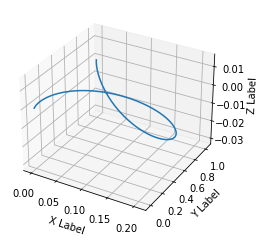

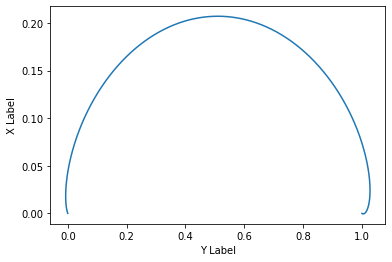

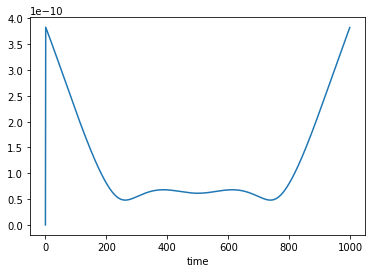

In [5]:
# plot trajectory
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

x_trajectory = [x_0[0][0]]
y_trajectory = [x_0[1][0]]
z_trajectory = [x_0[2][0]]

x_i = x_0
# get x,y,z values for plotting
for i in range(1,numSteps+1):
    #x_i = moveOneStep(x_i, u.value, timeStep, i)
    x_i = move(x_0, u.value, i, timeStep)
    # get first three elements of x_i
    x_trajectory.append(x_i[0][0])
    y_trajectory.append(x_i[1][0])
    z_trajectory.append(x_i[2][0])

print("Final Position")
print((x_trajectory[-1], y_trajectory[-1], z_trajectory[-1]))
# print sizes

# plot trajectory
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot(x_trajectory, y_trajectory, z_trajectory)
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

fig = plt.figure()
ax = fig.add_subplot()
ax.plot(y_trajectory, x_trajectory)
ax.set_xlabel('Y Label')
ax.set_ylabel('X Label')

# plot usage of thrust magnitude at each time step
thrust = [ math.sqrt(u.value[i][0]**2 + u.value[i][1]**2 + u.value[i][2]**2) for i in range(numSteps)]
#print(thrust)
plt.figure()
plt.plot(thrust)
plt.xlabel('time')

plt.show()